### Imporing Libaraies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

### Reading Data

In [2]:
dt = pd.read_csv(r"Data\Data_pout.csv", low_memory=False)

# del dt['comments']
# del dt['sensor_cleaning']

#printing summary of data
print(round(dt.describe(),2))

         ghi_pyr        dni        dhi  air_temperature  relative_humidity  \
count  461849.00  461849.00  461849.00        461849.00          461849.00   
mean      192.90     157.33      86.58            23.45              62.42   
std       276.57     248.98     119.25             8.22              21.73   
min         0.00       0.00       0.00             0.80               3.00   
25%         0.00       0.00       0.00            17.00              45.50   
50%         0.70       0.00       1.50            24.80              64.10   
75%       360.20     293.90     157.70            29.60              80.50   
max      1140.00    1029.20     710.80            46.10             100.00   

       wind_speed  wind_speed_of_gust  wind_from_direction_st_dev  \
count   461849.00           461849.00                   461849.00   
mean         2.32                3.86                       11.97   
std          1.72                2.60                        9.73   
min          0.00    

### Checking for missing values and filling them

In [3]:
print(dt.isnull().sum())

time                          0
ghi_pyr                       0
dni                           0
dhi                           0
air_temperature               0
relative_humidity             0
wind_speed                    0
wind_speed_of_gust            0
wind_from_direction_st_dev    0
wind_from_direction           0
barometric_pressure           0
actual_date                   0
day_lenght                    0
longitude                     0
latitude                      0
hour                          0
day_of_week                   0
month                         0
season                        0
Hour_sin                      0
Hour_cos                      0
sine_mon                      0
cos_mon                       0
Effective_Irradiance          0
Adjusted_Efficiency           0
P_solar                       0
dtype: int64


### Visulaizing Data Using Corealtion Matrix

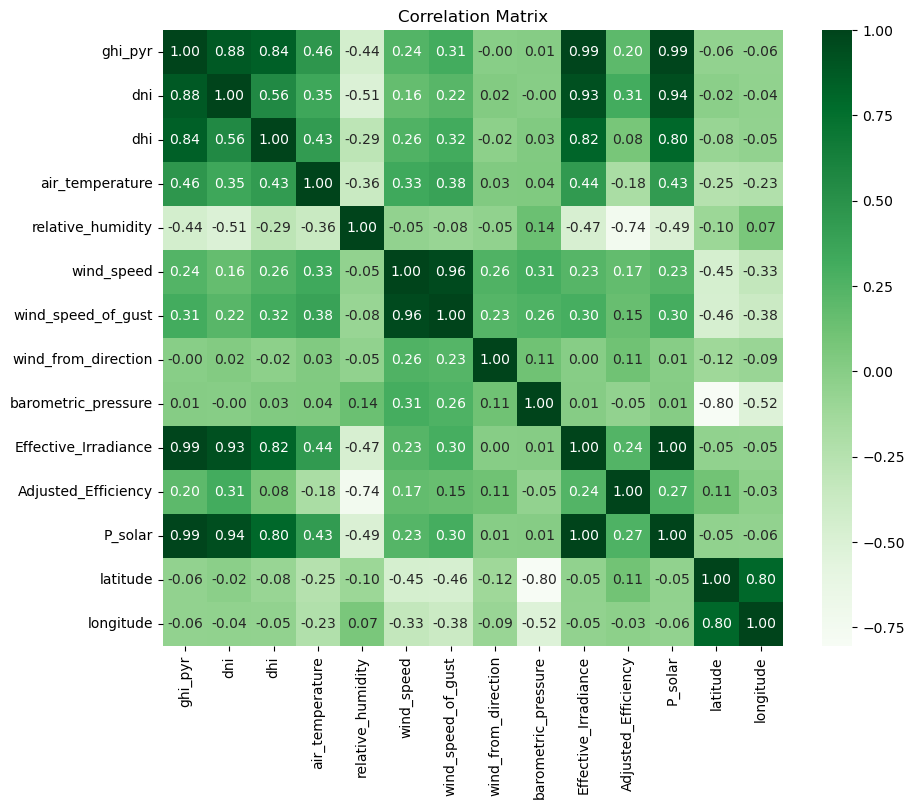

In [4]:
columns_of_interest = [
    'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity',
    'wind_speed', 'wind_speed_of_gust', 'wind_from_direction', 'barometric_pressure',
    'Effective_Irradiance', 'Adjusted_Efficiency', 'P_solar', 'latitude', 'longitude'
]
corr_data = dt[columns_of_interest]

# Calculating the correlation matrix
corr_matrix = corr_data.corr()
#corr_matrix.style.background_gradient(cmap='Greens').format(".2f")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Greens", cbar=True)
plt.title("Correlation Matrix")
plt.show()

### Feature Engineering (extract time features and add latitude/longitude)

C:\Users\talha\AppData\Local\Temp\ipykernel_13720\838611739.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dt['hour'] = pd.to_datetime(dt['time']).dt.hour
C:\Users\talha\AppData\Local\Temp\ipykernel_13720\838611739.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dt['day_of_week'] = pd.to_datetime(dt['time']).dt.dayofweek
C:\Users\talha\AppData\Local\Temp\ipykernel_13720\838611739.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dt['month'] = pd.to_datetime(dt['time']).dt.month


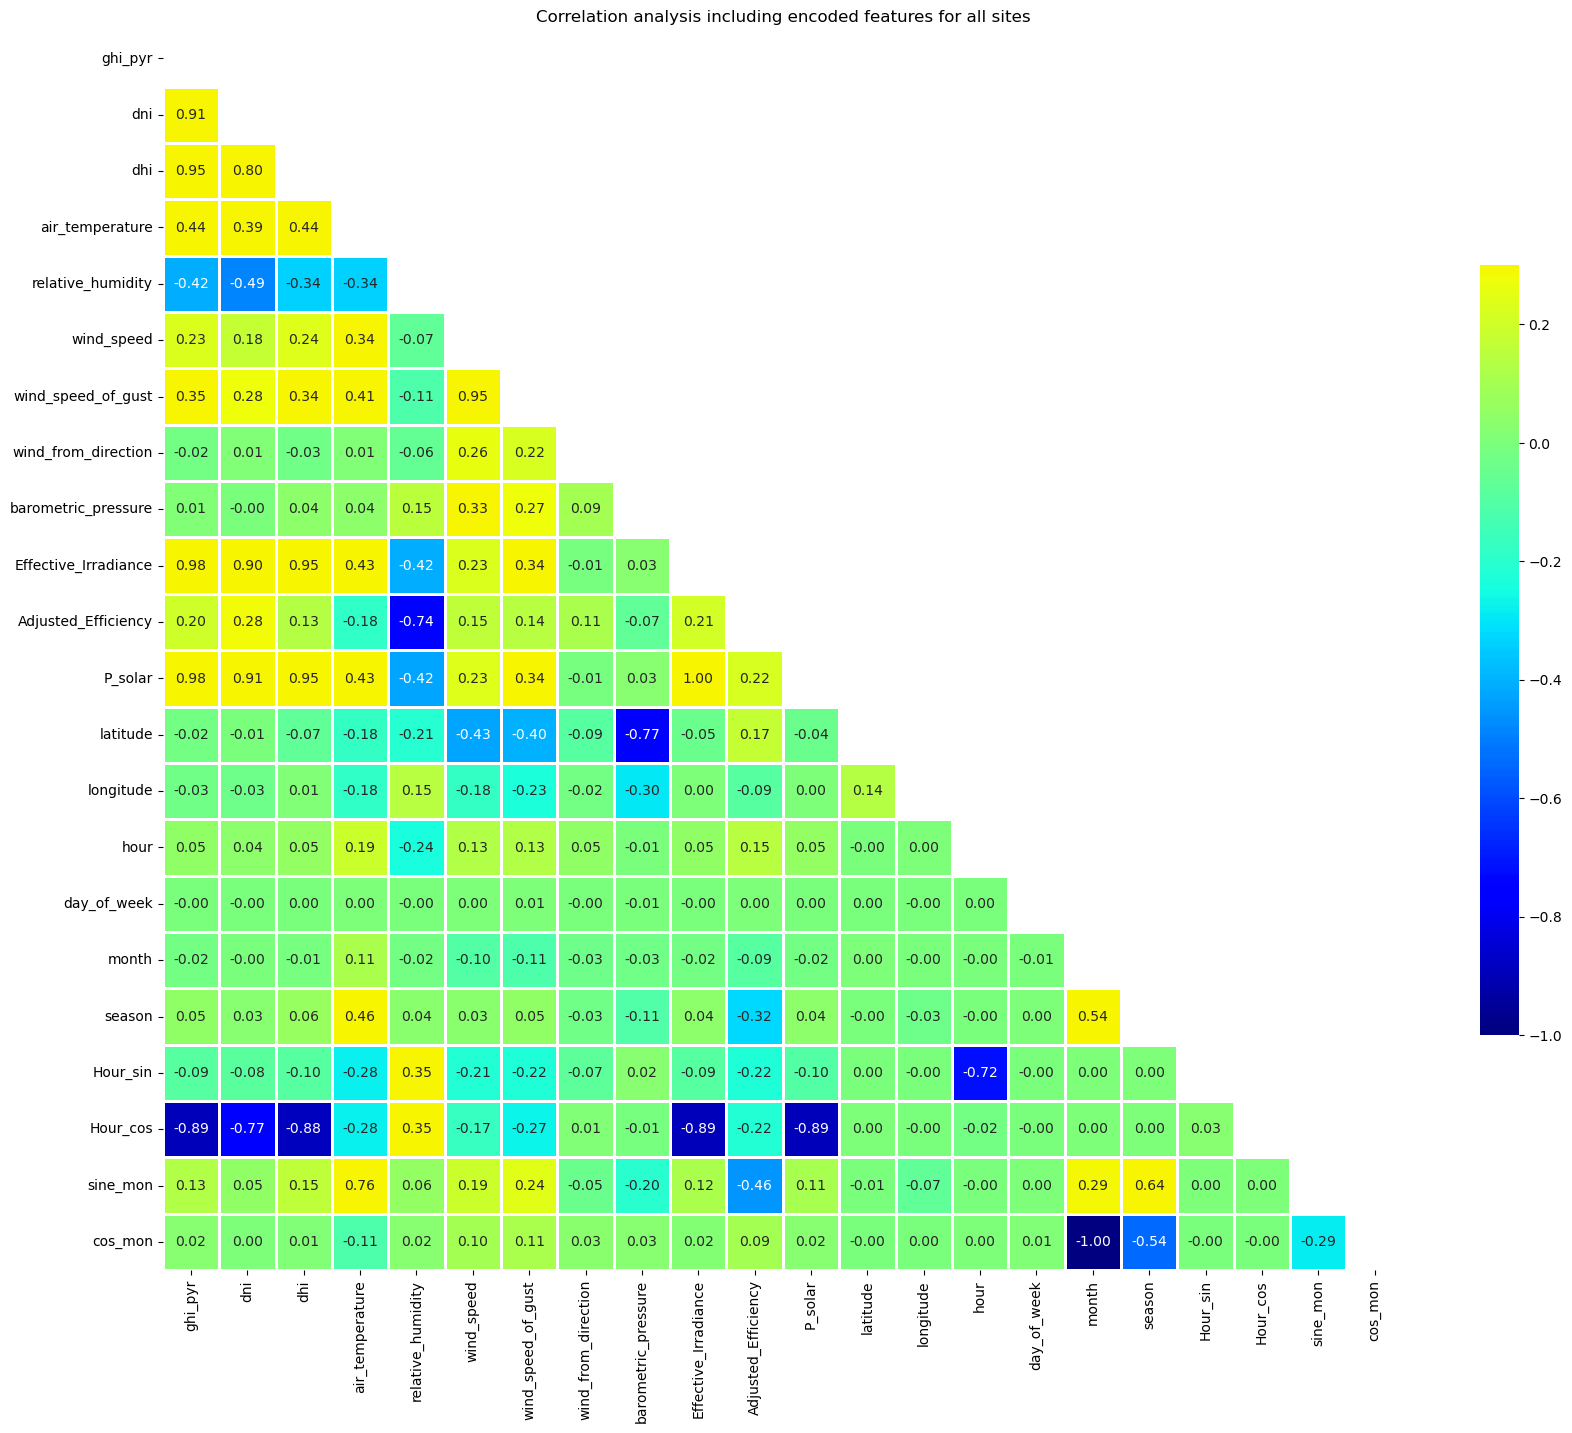

In [ ]:


# Feature Engineering (extract time features and add latitude/longitude)
dt['hour'] = pd.to_datetime(dt['time']).dt.hour
dt['day_of_week'] = pd.to_datetime(dt['time']).dt.dayofweek
dt['month'] = pd.to_datetime(dt['time']).dt.month
dt['season'] = dt['month'].apply(lambda x: (x % 12 + 3) // 3)  # Quarter of the year

# Create cyclic features for 'hour' and 'month'
max_hour_value = dt['hour'].max()
dt['Hour_sin'] = np.sin(2 * np.pi * dt['hour'] / max_hour_value)
dt['Hour_cos'] = np.cos(2 * np.pi * dt['hour'] / max_hour_value)

dt['sine_mon'] = np.sin((dt['month'] - 1) * np.pi / 12)
dt['cos_mon'] = np.cos((dt['month'] - 1) * np.pi / 12)

# # Save the updated DataFrame with new features to a CSV file
# dt.to_csv(r'C:\Users\talha\OneDrive\Desktop\EM Project-20241214T123152Z-001\EM Project\Updated_Features.csv', index=False)


columns_of_interest = [
    'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity',
    'wind_speed', 'wind_speed_of_gust', 'wind_from_direction', 'barometric_pressure',
    'Effective_Irradiance', 'Adjusted_Efficiency', 'P_solar', 'latitude', 'longitude', 'hour', 'day_of_week', 'month', 'season', 'Hour_sin', 'Hour_cos', 'sine_mon', 'cos_mon'
]


# Now let's create a correlation matrix and plot it using a heatmap
mask2 = np.triu(np.ones_like(dt[columns_of_interest].corr(), dtype=bool))

# Plot correlation heatmap using Spearman method
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(dt[columns_of_interest].corr(method='spearman'), mask=mask2, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.9, cbar_kws={"shrink": .5})
plt.title('Correlation analysis including encoded features for all sites')
plt.show()


### Visualize missing values

Text(0.5, 1.0, 'Visualize missing values in datasets')

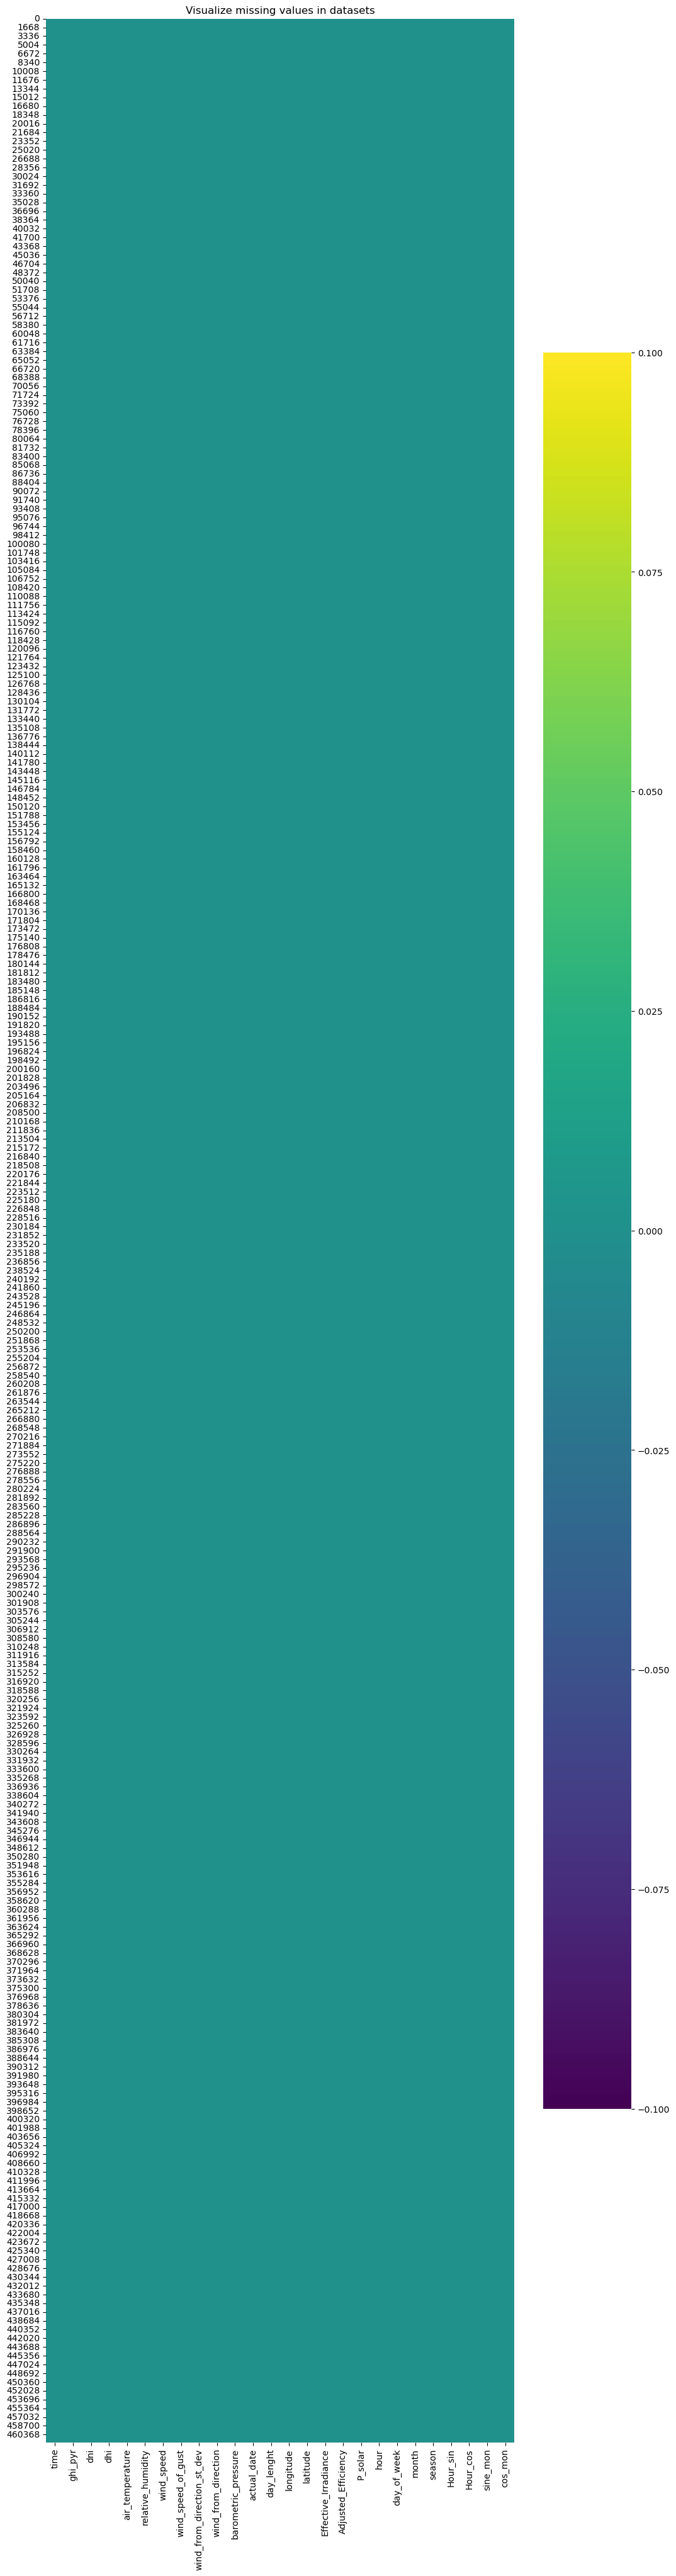

In [7]:
plt.figure(figsize=(12, 50))

# dt = pd.read_csv(r"C:\Users\talha\OneDrive\Desktop\EM Project\Updated_Features.csv", low_memory=False)


sns.heatmap(dt.isnull(), cmap='viridis')
plt.title('Visualize missing values in datasets')

### Using model

In [8]:
columns_of_interest_x = [
    'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity',
    'wind_speed', 'wind_speed_of_gust', 'wind_from_direction', 'barometric_pressure',
]


X = dt[columns_of_interest_x]
y= dt['P_solar']


# del X['actual_date']
# del X['time']



In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461849 entries, 0 to 461848
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ghi_pyr              461849 non-null  float64
 1   dni                  461849 non-null  float64
 2   dhi                  461849 non-null  float64
 3   air_temperature      461849 non-null  float64
 4   relative_humidity    461849 non-null  float64
 5   wind_speed           461849 non-null  float64
 6   wind_speed_of_gust   461849 non-null  float64
 7   wind_from_direction  461849 non-null  float64
 8   barometric_pressure  461849 non-null  float64
dtypes: float64(9)
memory usage: 31.7 MB


In [10]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 461849 entries, 0 to 461848
Series name: P_solar
Non-Null Count   Dtype  
--------------   -----  
461849 non-null  float64
dtypes: float64(1)
memory usage: 3.5 MB


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

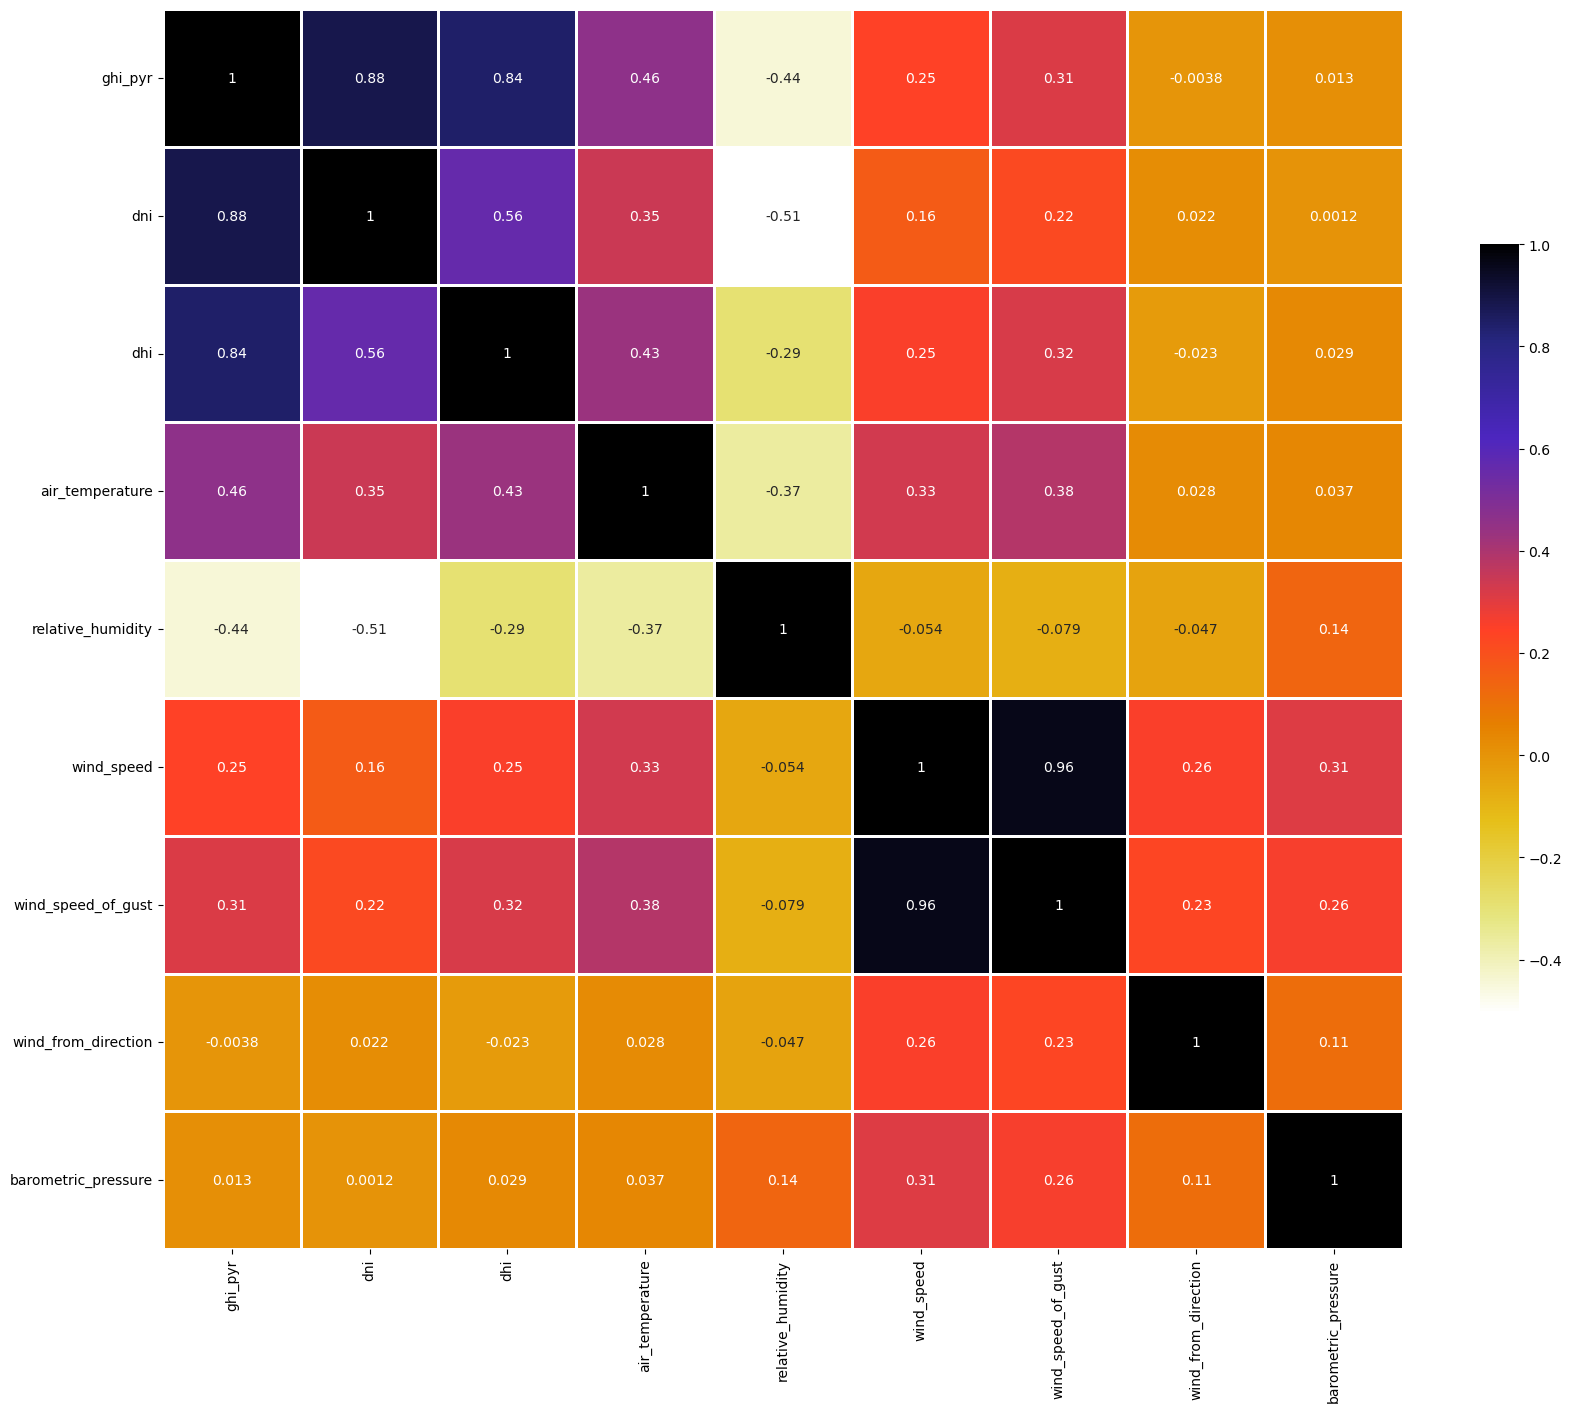

In [12]:
plt.figure(figsize=(20,20))


columns_of_interest_x = [
    'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity',
    'wind_speed', 'wind_speed_of_gust', 'wind_from_direction', 'barometric_pressure',
]



cor=X_train[columns_of_interest_x].corr()
sns.heatmap(cor,annot=True, cmap=plt.cm.CMRmap_r, square=True, linewidths=.9, cbar_kws={"shrink": .5})
plt.show()

In [29]:
# def correlation(dataset, threshold):
#     col_corr = set()
#     corr_matrix = dataset.corr()
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i):
#             if (corr_matrix.iloc[i,j]) > threshold:
#                 colname = corr_matrix.columns[i]
#                 col_corr.add(colname)
#     return col_corr

In [30]:
# columns_of_interest = [
#     'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity',
#     'wind_speed', 'wind_speed_of_gust', 'wind_from_direction', 'barometric_pressure',
#     'Effective_Irradiance', 'Adjusted_Efficiency', 'latitude', 'longitude', 'hour', 'day_of_week', 'month', 'season', 'Hour_sin', 'Hour_cos', 'sine_mon', 'cos_mon'
# ]

# corr_features = correlation(X_train[columns_of_interest], 0.9)
# len(set(corr_features))


# corr_features

{'Effective_Irradiance', 'wind_speed_of_gust'}

In [31]:
# X_train.drop(corr_features, axis=1)
# X_test.drop(corr_features, axis=1)

,ghi_pyr,dni,dhi,air_temperature,relative_humidity,wind_speed,wind_from_direction_st_dev,wind_from_direction,barometric_pressure,day_lenght,...,latitude,Adjusted_Efficiency,hour,day_of_week,month,season,Hour_sin,Hour_cos,sine_mon,cos_mon
75763,0.0,0.0,0.0,31.1,65.6,1.5,6.9,120.6,936.0,853,...,33.68,0.15,19,1,7,3,-8.878852e-01,0.460065,1.000000,6.123234e-17
401856,443.3,503.5,162.0,23.3,47.6,1.1,10.2,63.5,971.0,706,...,34.01,0.17,9,3,3,2,6.310879e-01,-0.775711,0.500000,8.660254e-01
266127,541.3,37.0,468.6,31.5,81.7,3.8,12.1,122.7,977.1,809,...,31.52,0.15,10,6,8,3,3.984011e-01,-0.917211,0.965926,-2.588190e-01
42775,0.0,0.0,0.0,12.3,71.3,0.9,9.4,29.1,949.5,612,...,33.68,0.16,23,2,11,4,-2.449294e-16,1.000000,0.500000,-8.660254e-01
189979,0.0,0.0,0.0,27.0,85.6,5.2,18.8,226.8,997.8,752,...,24.86,0.16,3,0,9,4,7.308360e-01,0.682553,0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363731,650.6,490.4,250.1,41.2,32.1,3.5,18.2,21.6,952.6,865,...,34.01,0.16,15,4,6,3,-8.169699e-01,-0.576680,0.965926,2.588190e-01
55142,0.0,0.0,0.0,12.3,90.5,2.8,15.1,341.6,951.6,665,...,33.68,0.16,20,4,2,1,-7.308360e-01,0.682553,0.258819,9.659258e-01
18034,0.0,0.0,0.0,14.7,49.5,1.9,7.1,291.7,949.3,682,...,33.68,0.17,18,4,2,1,-9.790841e-01,0.203456,0.258819,9.659258e-01
247457,0.0,0.0,0.0,19.0,91.6,4.4,12.8,79.9,981.8,749,...,31.52,0.16,19,2,4,2,-8.878852e-01,0.460065,0.707107,7.071068e-01


#### Perform Cross-Validation on training data for hyper parameter tuning

In [13]:
# Create list of each hyper-param to tune
n_estimators_list = [int(50*x) for x in range(2, 30)]

learning_rate_list = [round(x/500, 4) for x in range(2, 25)]

max_depth_list = [int(x) for x in range(3, 13)]
max_depth_list.append(-1)

n_leaves_list = [int(50*x) for x in range(2, 30)]

feature_fraction_list = [x/10 for x in range(1, 10)]

objective_list = ['rmse', 'mae', 'mape']







# Structure model hyper-params as a dictionary
lgbm_grid = {'num_leaves':n_leaves_list,
             'max_depth':max_depth_list,
             'learning_rate':learning_rate_list,
             'n_estimators':n_estimators_list,
             'feature_fraction':feature_fraction_list,
             'objective':objective_list}



# Create base LGBM model
lgbm_base = LGBMRegressor()



# Create random search for LGBM model
lgbm_random = RandomizedSearchCV(estimator=lgbm_base, param_distributions=lgbm_grid,
                                 n_iter=200, cv=4, verbose=2, random_state=42,
                                 n_jobs=-1)





#### Random Search Cv

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323294 entries, 99853 to 176991
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ghi_pyr              323294 non-null  float64
 1   dni                  323294 non-null  float64
 2   dhi                  323294 non-null  float64
 3   air_temperature      323294 non-null  float64
 4   relative_humidity    323294 non-null  float64
 5   wind_speed           323294 non-null  float64
 6   wind_speed_of_gust   323294 non-null  float64
 7   wind_from_direction  323294 non-null  float64
 8   barometric_pressure  323294 non-null  float64
dtypes: float64(9)
memory usage: 24.7 MB


In [16]:
%%time
# Fit the random search LGBM model with verbose output
lgbm_random.fit(X_train, y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2102
[LightGBM] [Info] Number of data points in the train set: 323294, number of used features: 9
[LightGBM] [Info] Start training from score 71.908628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: total: 2min 24s
Wall time: 3h 25min 4s


RandomizedSearchCV(cv=4, estimator=LGBMRegressor(), n_iter=200, n_jobs=-1,
                   param_distributions={'feature_fraction': [0.1, 0.2, 0.3, 0.4,
                                                             0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.004, 0.006, 0.008,
                                                          0.01, 0.012, 0.014,
                                                          0.016, 0.018, 0.02,
                                                          0.022, 0.024, 0.026,
                                                          0.028, 0.03, 0.032,
                                                          0.034, 0.036, 0.038,
                                                          0.04, 0.042, 0.044,
                                                          0.046, 0.048],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12, -1],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500, 550, 600, 650,
                                                         700, 750, 800, 850,
                                                         900, 950, 1000, 1050,
                                                         1100, 1150, 1200, 1250,
                                                         1300, 1350, 1400,
                                                         1450],
                                        'num_leaves': [100, 150, 200, 250, 300,
                                                       350, 400, 450, 500, 550,
                                                       600, 650, 700, 750, 800,
                                                       850, 900, 950, 1000,
                                                       1050, 1100, 1150, 1200,
                                                       1250, 1300, 1350, 1400,
                                                       1450],
                                        'objective': ['rmse', 'mae', 'mape']},
                   random_state=42, verbose=2)

In [17]:
# Get optimal hyper-params
lgbm_random.best_params_

{'objective': 'rmse',
 'num_leaves': 200,
 'n_estimators': 1000,
 'max_depth': 11,
 'learning_rate': 0.028,
 'feature_fraction': 0.9}

In [18]:
# Get score of best model during hyper-param tuning
lgbm_random.best_score_

0.9999475501216697

In [19]:
mean_score = lgbm_random.cv_results_['mean_test_score']
std_score = lgbm_random.cv_results_['std_test_score']
params = lgbm_random.cv_results_['params']

In [20]:
cv_score_df = pd.DataFrame(params)
cv_score_df['mean_score'] = mean_score
cv_score_df['std_score'] = std_score

In [21]:
cv_score_df.to_csv(r'Weights\lgbm_141224.csv', index=False)

In [22]:
all_results_cv_df = pd.DataFrame(lgbm_random.cv_results_)

In [23]:
all_results_cv_df.to_csv(r'Weights\lgbm_141224.csv', index=False)

#### Train model using optimal hyper parameter from above

In [24]:
# Random
lgbm_model = LGBMRegressor(objective        = lgbm_random.best_params_['objective'],
                           num_leaves       = lgbm_random.best_params_['num_leaves'],
                           n_estimators     = lgbm_random.best_params_['n_estimators'],
                           max_depth        = lgbm_random.best_params_['max_depth'],
                           learning_rate    = lgbm_random.best_params_['learning_rate'],
                           feature_fraction = lgbm_random.best_params_['feature_fraction'],
                           random_state     = 42)

In [25]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 323294, number of used features: 9
[LightGBM] [Info] Start training from score 71.908628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(feature_fraction=0.9, learning_rate=0.028, max_depth=11,
              n_estimators=1000, num_leaves=200, objective='rmse',
              random_state=42)

#### Make model inferences on test set

In [26]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138555 entries, 75763 to 253963
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ghi_pyr              138555 non-null  float64
 1   dni                  138555 non-null  float64
 2   dhi                  138555 non-null  float64
 3   air_temperature      138555 non-null  float64
 4   relative_humidity    138555 non-null  float64
 5   wind_speed           138555 non-null  float64
 6   wind_speed_of_gust   138555 non-null  float64
 7   wind_from_direction  138555 non-null  float64
 8   barometric_pressure  138555 non-null  float64
dtypes: float64(9)
memory usage: 10.6 MB


In [27]:
y_pred = lgbm_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


In [28]:
y_pred
y_test

contains_nan1 = np.isnan(y_pred).any()
contains_nan2 = np.isnan(y_test).any()
print("Contains NaN values:", contains_nan1)
print("Contains NaN values:", contains_nan2)

Contains NaN values: False
Contains NaN values: False


#### Evaluate model performance on test set

In [29]:
# Explained variance

# y_test.to_csv('y_test.csv', index=False, float_format='%.2f')



explained_variance_score(y_test.ravel(), y_pred)

C:\Users\talha\AppData\Local\Temp\ipykernel_13720\903767755.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  explained_variance_score(y_test.ravel(), y_pred)


0.9999562875471049

In [30]:
# R2 score
r2_score(y_test.ravel(), y_pred)

C:\Users\talha\AppData\Local\Temp\ipykernel_13720\1930752761.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  r2_score(y_test.ravel(), y_pred)


0.9999562873349469

In [31]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.3287434592113036
MSE: 0.43800614309673713
RMSE: 0.6618203253880445


In [32]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [33]:
mean_absolute_percentage_error(y_test.ravel(), y_pred)*100

C:\Users\talha\AppData\Local\Temp\ipykernel_13720\2914079674.py:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  mean_absolute_percentage_error(y_test.ravel(), y_pred)*100


194.14096648704705

Text(0, 0.5, 'Predicted Y')

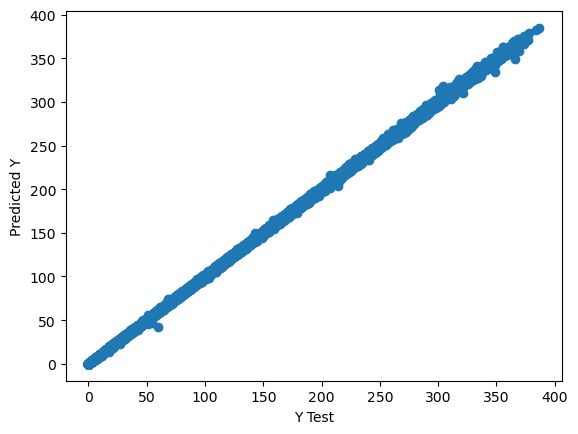

In [34]:
plt.scatter(y_test,y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

#### Prediction on full dataset

In [35]:
y_all_pred = lgbm_model.predict(X.values)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


In [36]:
y_all_pred

array([2.48687919e+02, 2.47610460e+02, 2.43397716e+02, ...,
       3.18942061e-03, 1.22637458e-03, 1.43024996e-03])

In [37]:
r2_score(y.values, y_all_pred)

0.999972300739829

In [38]:
# Import the required libraries
import pandas as pd

# Predict the output using the model
predictions = lgbm_model.predict(X.values)

# Calculate the error and percentage error
error = abs(predictions - y)
percentage_error = (error / y) * 100

# Create a DataFrame with Predicted, Actual, Error, and Percentage Error columns
results = pd.DataFrame({
    "Predicted": predictions,
    "Actual": y,
    "Error": error,
    "Percentage_Error": percentage_error
})[["Predicted", "Actual", "Error", "Percentage_Error"]]

# Save the DataFrame to a CSV file
results.to_csv("predictions_1412_results.csv", index=False)

# Print statements for output verification
print(f"True output: {y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {error[0]}")
print(f"Percentage Error: {percentage_error[0]}%")

print("Predictions have been saved to 'predictions_1412_results.csv'")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
True output: 248.96
Predicted output: 248.68791933332537
Prediction Error: 0.2720806666746398
Percentage Error: 0.10928690017458217%
Predictions have been saved to 'predictions_1412_results.csv'


In [39]:
pd.DataFrame({"Predicted": predictions, "Actual": y, "Error": error, "Percentage Error":percentage_error })[["Predicted", "Actual", "Error", "Percentage Error"]]



,Predicted,Actual,Error,Percentage Error
0,248.687919,248.96,0.272081,0.109287
1,247.610460,246.71,0.900460,0.364987
2,243.397716,243.74,0.342284,0.140430
3,236.154156,236.42,0.265844,0.112446
4,233.726205,232.98,0.746205,0.320287
...,...,...,...,...
461844,0.001537,0.00,0.001537,inf
461845,0.002524,0.00,0.002524,inf
461846,0.003189,0.00,0.003189,inf
461847,0.001226,0.00,0.001226,inf


In [40]:
import joblib
joblib.dump(lgbm_model, "EM Project\Saved_Models\saved_model_pout.pkl")


['saved_model_LGBM.pkl']